In [12]:
# Importing necessary libraries for image processing, matrix computation, and model building
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [13]:
# Function to load grayscale images from directory, resize them, and flatten
def load_images(dataset_dir, img_size=(128, 128)):
    images = []
    labels = []
    img_paths = []
    valid_exts = ('.jpg', '.jpeg', '.png')

    for person in sorted(os.listdir(dataset_dir)):
        person_path = os.path.join(dataset_dir, person)
        if os.path.isdir(person_path):
            for img_file in sorted(os.listdir(person_path)):
                if not img_file.lower().endswith(valid_exts):
                    print(f"[SKIP] Not an image: {img_file}")
                    continue
                img_path = os.path.join(person_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"[WARNING] Could not load: {img_path}")
                    continue
                img = cv2.resize(img, img_size)
                images.append(img.flatten())
                labels.append(person)
                img_paths.append(img_path)
        else:
            # Handle direct image files in imposter folder
            if person.lower().endswith(valid_exts):
                img_path = os.path.join(dataset_dir, person)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"[WARNING] Could not load: {img_path}")
                    continue
                img = cv2.resize(img, img_size)
                images.append(img.flatten())
                labels.append("imposter")
                img_paths.append(img_path)

    return np.array(images).T, np.array(labels), img_paths # Face_Db shape: (mn, p)


In [14]:
# Load face dataset and encode labels into numerical values
dataset_path = r"D:\AI Project\dataset\dataset\faces"
 # Change if needed
Face_Db, all_labels, image_paths = load_images(dataset_path)

# Encode labels into integers
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)


In [15]:
# Split the dataset into 60% training and 40% testing
total_indices = list(range(Face_Db.shape[1]))
train_indices, test_indices = train_test_split(
    total_indices, test_size=0.4, stratify=encoded_labels, random_state=42
)

# Save training and testing indices to CSV files
pd.DataFrame({'index': train_indices}).to_csv("train_indices.csv", index=False)
pd.DataFrame({'index': test_indices}).to_csv("test_indices.csv", index=False)

# Create training and testing datasets using the split indices
X_train = Face_Db[:, train_indices]
y_train = encoded_labels[train_indices]
X_test = Face_Db[:, test_indices]
y_test = encoded_labels[test_indices]


In [16]:
# PCA Step 1: Compute mean vector of training data
M = np.mean(X_train, axis=1, keepdims=True)

# PCA Step 2: Subtract the mean from each image to center the data
Delta = X_train - M

# PCA Step 3: Compute the surrogate covariance matrix
Cov = np.dot(Delta.T, Delta)

# PCA Step 4: Perform eigen decomposition
eigvals, eigvecs = np.linalg.eigh(Cov)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(-eigvals)
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]


In [17]:
# Function to perform PCA + ANN training and testing for different k values
def run_ann_pca(k_values):
    results = []
    saved_models = []
    saved_eigfaces = []

    for k in k_values:
        print(f"\n[INFO] Evaluating for k = {k}")

        # Select top-k eigenvectors (feature directions)
        Psi = eigvecs[:, :k]

        # Compute eigenfaces: Delta × Psi
        eigfaces = np.dot(Delta, Psi)
        eigfaces = eigfaces / np.linalg.norm(eigfaces, axis=0)

        # Project training data into PCA space
        omega_train = np.dot(eigfaces.T, Delta)

        # Project test data into PCA space
        Delta_test = X_test - M
        omega_test = np.dot(eigfaces.T, Delta_test)

        # Define and train the ANN model
        model = Sequential([
            Input(shape=(k,)),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(omega_train.T, y_train, epochs=20, batch_size=8, verbose=0)

        # Predict and evaluate accuracy
        y_pred = model.predict(omega_test.T)
        y_pred_labels = np.argmax(y_pred, axis=1)
        acc = accuracy_score(y_test, y_pred_labels)
        print(f"Accuracy for k = {k}: {acc:.4f}")

        # Save results
        results.append((acc, y_pred_labels))
        saved_models.append(model)
        saved_eigfaces.append(eigfaces)

    return results, saved_models, saved_eigfaces




[INFO] Evaluating for k = 10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy for k = 10: 0.1833

[INFO] Evaluating for k = 20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy for k = 20: 0.2278

[INFO] Evaluating for k = 30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Accuracy for k = 30: 0.2278

[INFO] Evaluating for k = 40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy for k = 40: 0.3556

[INFO] Evaluating for k = 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy for k = 50: 0.3833

[INFO] Evaluating for k = 60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy for k = 60: 0.2611


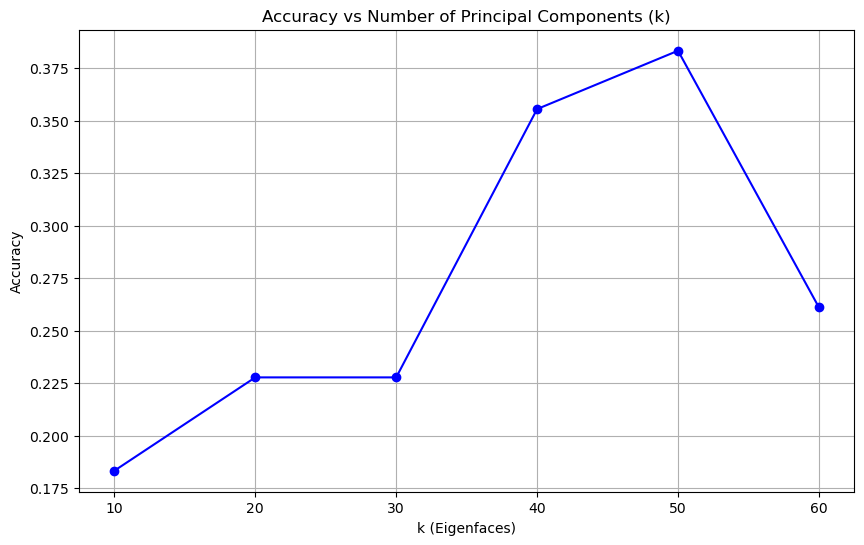

In [18]:
k_values = [10, 20, 30, 40, 50, 60]
# Run training + collect models and eigfaces
results, models, eigfaces_list = run_ann_pca(k_values)

# Split accuracy and predictions
accuracies = [acc for acc, _ in results]  # just take the first part of each tuple

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title("Accuracy vs Number of Principal Components (k)")
plt.xlabel("k (Eigenfaces)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



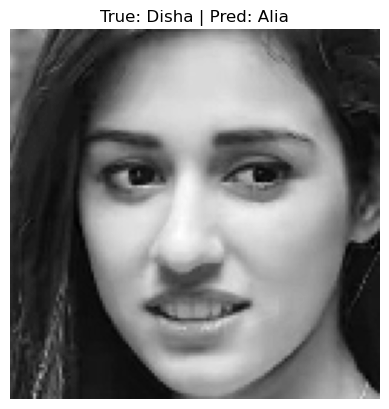

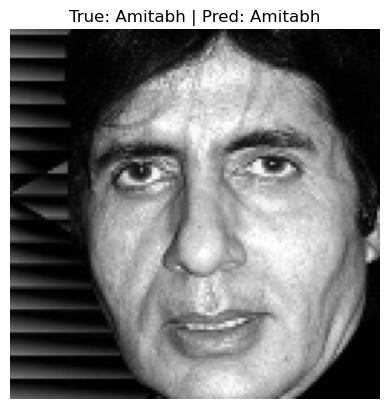

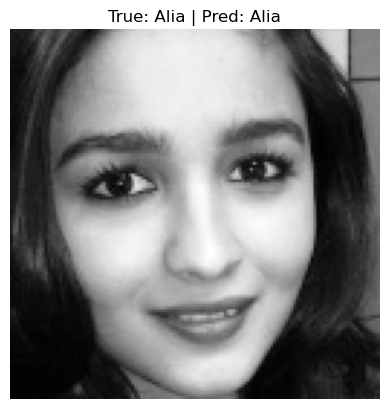

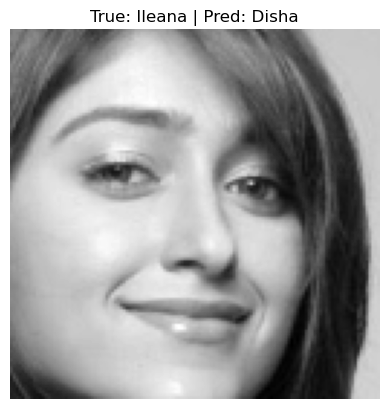

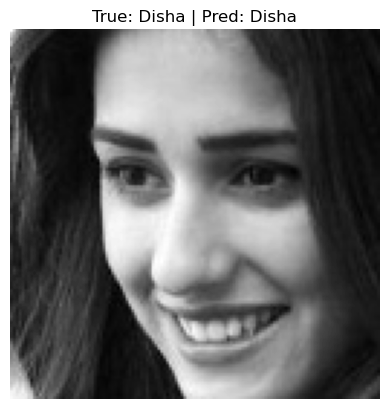

In [19]:
# Show 5 test faces with predicted labels (last k used)
final_pred = results[-1][1]  # predictions for k=60
for i in range(5):
    idx = test_indices[i]
    img = Face_Db[:, idx].reshape(128, 128)

    true_name = le.inverse_transform([y_test[i]])[0]
    pred_name = le.inverse_transform([final_pred[i]])[0]

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_name} | Pred: {pred_name}")
    plt.axis('off')
    plt.show()



In [20]:
# Load imposter images
imposter_faces, _, _ = load_images(r"D:\AI Project\dataset\dataset\imposters", img_size=(128, 128))
print("Imposter shape:", imposter_faces.shape)

results, models, eigfaces_list = run_ann_pca(k_values)

model = models[-1]  # ANN trained at k=60
eigfaces = eigfaces_list[-1]  # PCA eigenfaces for k=60


Imposter shape: (16384, 5)

[INFO] Evaluating for k = 10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy for k = 10: 0.1833

[INFO] Evaluating for k = 20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Accuracy for k = 20: 0.2722

[INFO] Evaluating for k = 30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy for k = 30: 0.2500

[INFO] Evaluating for k = 40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy for k = 40: 0.1889

[INFO] Evaluating for k = 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy for k = 50: 0.2389

[INFO] Evaluating for k = 60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy for k = 60: 0.3944


In [23]:
# Mean-center the imposter faces
Delta_imposter = imposter_faces - M

# Project imposters to PCA space
omega_imposter = eigfaces.T @ Delta_imposter

# Predict using trained ANN
model = models[-1]  
y_pred_imp = model.predict(omega_imposter.T) 
y_pred_labels_imp = np.argmax(y_pred_imp, axis=1)
confidences = np.max(y_pred_imp, axis=1)

# Distance-based threshold (Euclidean distance in PCA space)
omega_train = eigfaces.T @ (X_train - M)
distances = []
for i in range(omega_imposter.shape[1]):
    test_vec = omega_imposter[:, i]
    dists = np.linalg.norm(omega_train.T - test_vec.T, axis=1)
    min_dist = np.min(dists)
    distances.append(min_dist)

# Set a distance threshold dynamically (mean + 2 std dev from training data)
dist_array = np.linalg.norm(omega_train.T - omega_train.T.mean(axis=0), axis=1)
distance_threshold = dist_array.mean() + 2 * dist_array.std()

# Print all distances and threshold for reference
print("Imposter distances:", distances)
print("Distance threshold:", distance_threshold)

# Classify imposters as REJECTED if they exceed threshold
for i, dist in enumerate(distances):
    status = "REJECTED" if dist > distance_threshold else "ACCEPTED"
    print(f"Imposter {i+1}: Distance = {dist:.2f} → {status}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Imposter distances: [6088.850982634369, 5503.968877464605, 4846.571060091355, 6447.82386740496, 8345.103515070665]
Distance threshold: 9645.309133861261
Imposter 1: Distance = 6088.85 → ACCEPTED
Imposter 2: Distance = 5503.97 → ACCEPTED
Imposter 3: Distance = 4846.57 → ACCEPTED
Imposter 4: Distance = 6447.82 → ACCEPTED
Imposter 5: Distance = 8345.10 → ACCEPTED


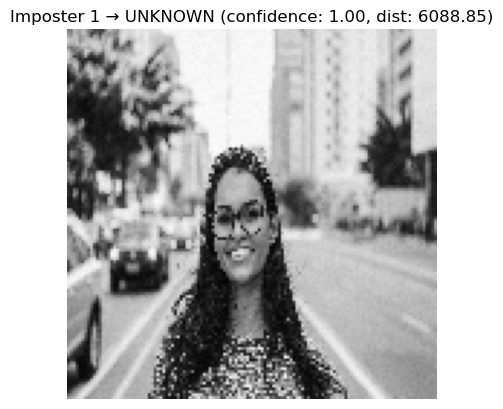

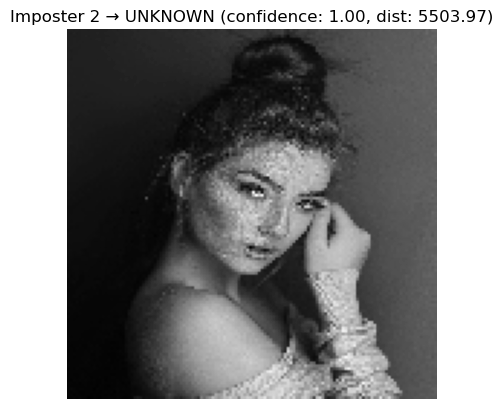

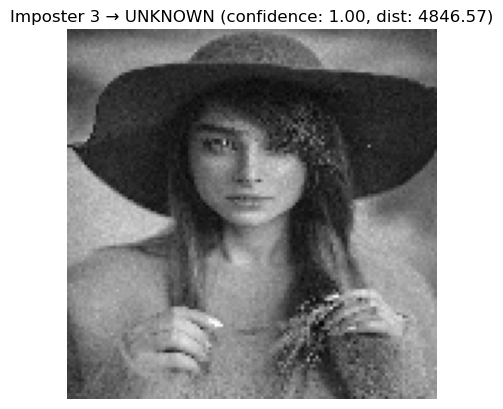

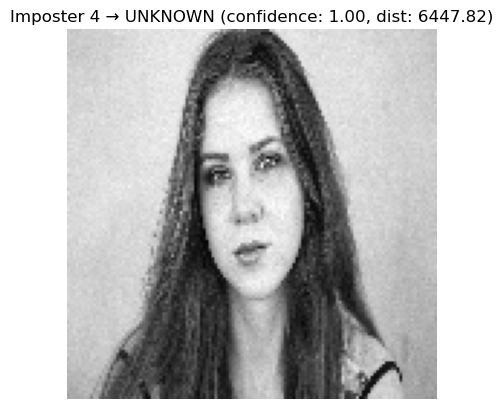

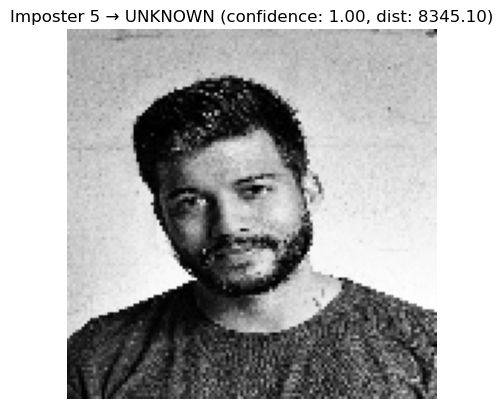

In [24]:
# Set a manual threshold for testing
threshold = 4000  # Based on analysis it can chane

# Loop through each imposter face to classify and visualize
for i in range(imposter_faces.shape[1]):
    img = imposter_faces[:, i].reshape(128, 128)
    conf = confidences[i]
    test_face = omega_imposter[:, i]
    
    # Compute minimum distance from train signatures
    dists = np.linalg.norm(omega_train - test_face[:, np.newaxis], axis=0)
    min_dist = np.min(dists)
    
    # Decision rule: if either confidence is low or distance is high → UNKNOWN
    if conf < 0.5 or min_dist > threshold:
        label = "UNKNOWN"
    else:
        label = le.inverse_transform([y_pred_labels_imp[i]])[0]
        
   # Visualize imposter result with decision
    plt.imshow(img, cmap='gray')
    plt.title(f"Imposter {i+1} → {label} (confidence: {conf:.2f}, dist: {min_dist:.2f})")
    plt.axis('off')
    plt.show()



In [26]:
import os
os.getcwd()


'C:\\Users\\Admin'